In [54]:
import numpy as np
import matplotlib.pyplot as plt
import time

import scipy.stats
from sklearn.decomposition import PCA

In [55]:
from data_helpers.wine_quality_data_helper import load_wine_quality_data
from data_helpers.mnist_data_helper import load_mnist_data

In [56]:
class PCAWrapper:
    NAME = 'PCA'
    def __init__(self, n_components) -> None:
        self.model = PCA(n_components=n_components)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)

    def transform(self, X):
        return self.model.transform(X)
    
    def get_kurtosis(self, X):
        X_star = self.model.fit_transform(X)
        kurtosis = scipy.stats.kurtosis(X_star).mean()
        return kurtosis

In [57]:
DATASET_NAME = 'mnist'
DATASET_STR = 'MNIST'

# DATASET_NAME = 'wine_quality'
# DATASET_STR = 'Wine Quality'

METHOD = PCAWrapper
K_FOLDS = 5
SAVE = True

In [58]:
if DATASET_NAME == 'wine_quality':
    X, y, _, _ = load_wine_quality_data()
elif DATASET_NAME == 'mnist':
    X, y, _, _ = load_mnist_data()
else:
    raise ValueError(f'Unknown dataset: {DATASET_NAME}')

In [59]:
n = X.shape[0] // K_FOLDS
i = 0

if DATASET_NAME == 'wine_quality':
    components = 11
elif DATASET_NAME == 'mnist':
    components = 196

X_train = np.concatenate([X[:i * n], X[(i + 1) * n:]])
y_train = np.concatenate([y[:i * n], y[(i + 1) * n:]])
X_test = X[i * n:(i + 1) * n]
y_test = y[i * n:(i + 1) * n]

model = METHOD(components)
t0 = time.perf_counter()
model.fit(X_train)
t1 = time.perf_counter()
training_time = t1 - t0

t0 = time.perf_counter()
_ = model.transform(X_test) 
t1 = time.perf_counter()
evaluation_time = t1 - t0

kurtosis = model.get_kurtosis(X_test)

Text(0.5, 1.0, 'PCA - MNIST - Explained Variance')

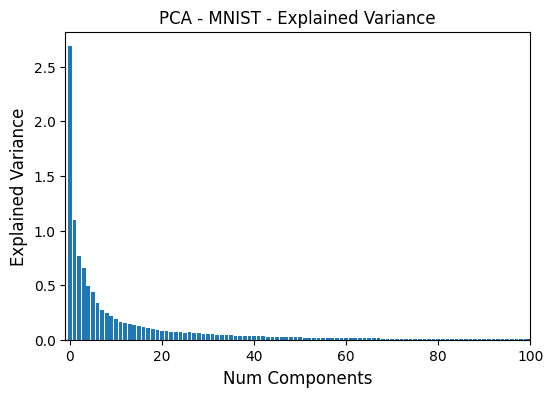

In [60]:
plt.figure(figsize=(6, 4))
n_samples = X.shape[0]
# We center the data and compute the sample covariance matrix.
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples
values = []
for eigenvector in model.model.components_:
    values.append(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
plt.bar(range(components), values)
plt.xlim([-1, 100])
plt.ylabel('Explained Variance', fontsize=12)
plt.xlabel('Num Components', fontsize=12)
plt.title(f'PCA - {DATASET_STR} - Explained Variance', fontsize=12)

In [61]:
model.model.explained_variance_ratio_.shape

(196,)

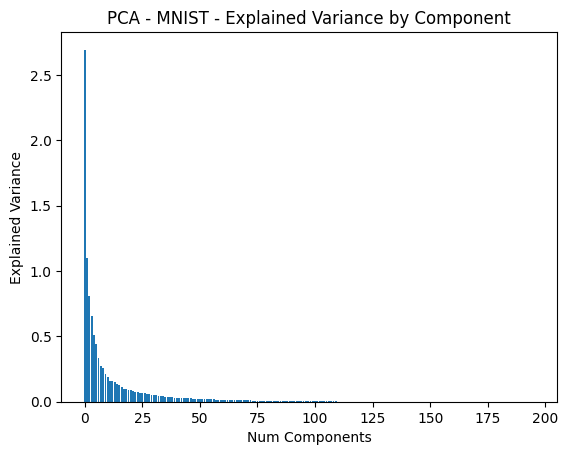

In [62]:
plt.bar(range(model.model.explained_variance_.shape[0]), model.model.explained_variance_)
plt.xlabel('Num Components')
plt.ylabel('Explained Variance')
plt.title(f'{METHOD.NAME} - {DATASET_STR} - Explained Variance by Component')
plt.savefig(f"figures/{DATASET_NAME}_{METHOD.NAME}_explained_variance.png")

In [63]:
df.columns

Index(['num_components', 'training_time_mean', 'training_time_std',
       'evaluation_time_mean', 'evaluation_time_std', 'mse_mean', 'mse_std'],
      dtype='object')

Text(0.5, 1.0, 'PCA - MNIST - Explained Variance and Accuracy')

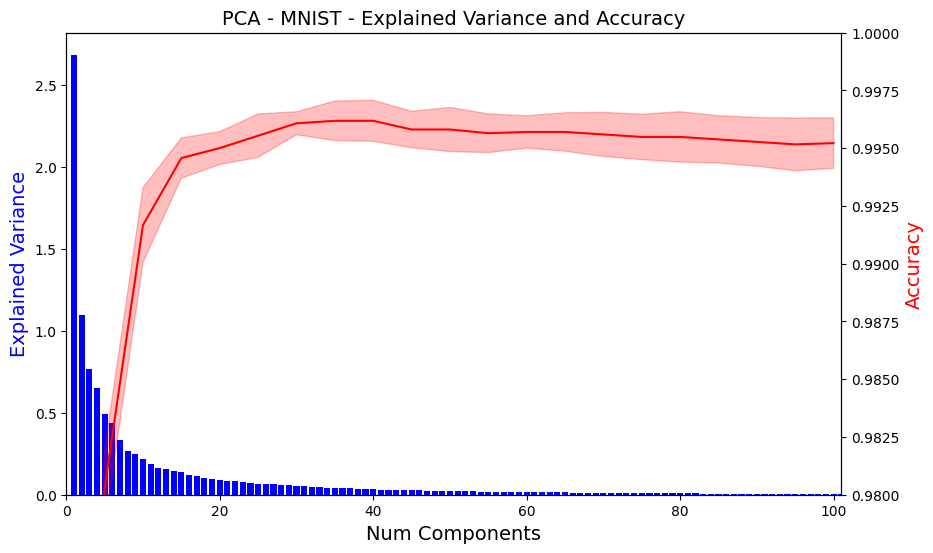

In [64]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

fontsize = 14
n_samples = X.shape[0]
# We center the data and compute the sample covariance matrix.
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples
values = []
for eigenvector in model.model.components_:
    values.append(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

ax1.bar(range(1, components+1), values, color='blue')

if DATASET_NAME == 'mnist':
    plt.xlim([0, 101])

ax1.set_ylabel('Explained Variance', fontsize=fontsize, color='blue')

ax1.set_xlabel('Num Components', fontsize=fontsize)

import pandas as pd

if DATASET_NAME == 'mnist':
    key = 'accuracy'
    key_str = 'Accuracy'
elif DATASET_NAME == 'wine_quality':
    key = 'mse'
    key_str = 'MSE'

df = pd.read_csv(f'results/{DATASET_NAME}/{METHOD.NAME}_metrics.csv')
df.sort_values('num_components', inplace=True)
ax2.plot(df['num_components'], df[f"{key}_mean"], label=key_str, color='red')
ax2.fill_between(df['num_components'], 
                 df[f"{key}_mean"] - df[f"{key}_std"], 
                 df[f"{key}_mean"] + df[f"{key}_std"], 
                 color='red',
                 alpha=0.25)
ax2.set_ylabel(key_str, fontsize=fontsize, color='red')

if DATASET_NAME == 'mnist':
    ax2.set_ylim(0.98, 1)

plt.title(f'PCA - {DATASET_STR} - Explained Variance and {key_str}', fontsize=fontsize)